# Project 3: Identifying Depression in r/domesticviolence Subreddit Posts
<img src="./images/domestic_violence.jpg" alt="domestic violence pic"/>

- [Webscraping and Data Collection](./1_Webscraping_and_Data_Collection.ipynb)
- [Preprocessing and EDA](./2_Preprocessing_and_EDA.ipynb)
- [Modeling - Multinomial Naive Bayes](./3_Modeling_Multinomial_Naive_Bayes.ipynb)
- [Modeling - Logistic Regression](./4_Modeling_Logistic_Regression.ipynb)
- <b>Modeling - Random Forest</b>
- [Production Model and Insights](./6_Production_Model_and_Insights.ipynb)

---
## Overview

Based on the features in the cleaned dataframe, I will now fit each feature, vectorized by Count Vectorization or TF-IDF Vectorization to a Random Forest model. I will then take the best performing model and optimise its hyperparameters and fit the model again. From there, I will be able to glean insights on how each feature in the model affects the prediction of the target vector (```is_depression```).

The best model will be taken into consideration for the final production model. 

---
## Contents
- [Importing libraries and data](#Importing-libraries-and-data)
- [Random forest model](#Random-forest-model)
- [Optimising parameters](#Optimising-parameters-for-random-forest-model)
- [Insights](#Insights-from-random-forest-model)
- [Conclusion](#Conclusion)

---
## Importing libraries and data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [8]:
model_df = pd.read_csv('./data/dv_depression_cleaned_for_model_final.csv')
model_df.head()

,is_depression,post,title,post_word_count,all_words
0,0,unless get extremely stoned often come stop th...,get intrusive thoughts memories physical abuse,261,get intrusive thoughts memories physical abuse...
1,1,saw george floyd clip know part cries mama mad...,kids afraid crying,363,kids afraid crying saw george floyd clip know ...
2,1,sexual relationships since lost virginity bu s...,nicotine replaced sexual urges,383,nicotine replaced sexual urges sexual relation...
3,1,well end year 5 days hand rest school work don...,hate school disappointment,613,hate school disappointment well end year 5 day...
4,1,anyone suffering depression job looking simple...,suffering depression job,61,suffering depression job anyone suffering depr...


In [9]:
#no null values
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   is_depression    1958 non-null   int64 
 1   post             1958 non-null   object
 2   title            1958 non-null   object
 3   post_word_count  1958 non-null   int64 
 4   all_words        1958 non-null   object
dtypes: int64(2), object(3)
memory usage: 76.6+ KB


---
## Random forest model

I created functions that would run and return the performance of a Count Vectorization with Logistic Regression model and TF-IDF Vectorization with Logistic Regression model on all feature columns, i.e., ```title```(words in title), ```post```(words in post), ```all_words```(all words in title and post). The dataframes below show the performance of each feature matrix.

The best model was TF-IDF Vectorization with Random Forest model with the ```all_words``` column as the feature matrix

It has the highest accuracy score and least variance between train and test scores. It also has the highest sensitivity, specificity, precision, ROC AUC score and f1-score

NB: Extra trees modelling was also done on the data with Count Vectorization and TF-IDF Vectorization. It did not perform better than Random trees, hence it was not used.

In [23]:
def cvec_rf_model(list_of_col):

    results_list = []
    for col in list_of_col:
    
    #features matrix(X) and target vector(y)
        X = model_df[col]
        y = model_df['is_depression']

        #train-test-split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                            stratify=y, 
                                                            random_state = 42)

        #instantiate cvec
        cvec = CountVectorizer()

        #fit and transform
        X_train = cvec.fit_transform(X_train).toarray()
        X_test = cvec.transform(X_test).toarray()

        #instantiate multinomial nb
        rf = RandomForestClassifier()

        #fit nb 
        rf.fit(X_train, y_train)

        #preds from nb model 
        pred = rf.predict(X_test)

        #generate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

        #calculate roc auc score 
        pred_proba = [i[1] for i in rf.predict_proba(X_test)]
        roc = roc_auc_score(y_test, pred_proba)

        #create table of results using dictionary
        results = {}
        results['features matrix (X)'] = col
        results['model'] = 'cvec + random forest'
        results['train accuracy score'] = rf.score(X_train, y_train)
        results['test accuracy score'] = rf.score(X_test, y_test)
        results['confusion matrix'] = {'tn':tn, 'fp': fp, 'fn': fn, 'tp': tp}
        results['sensitivity'] = tp/(tp+fn)
        results['specificity'] = tn/(tn+fp)
        results['precision'] = tp/(tp+fp)
        results['roc auc score'] = roc
        results['train f1-score'] = f1_score((rf.predict(X_train)), y_train)
        results['test f1-score'] = f1_score(pred, y_test)

        results 
        
        #append results dict to results_list
        results_list.append(results)
        
    #return dataframe of results for each model
    return(pd.DataFrame(results_list)).round(2)

In [24]:
def tvec_rf_model(list_of_col):

    results_list = []
    for col in list_of_col:
    
    #features matrix(X) and target vector(y)
        X = model_df[col]
        y = model_df['is_depression']

        #train-test-split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                            stratify=y, 
                                                            random_state = 42)

        #instantiate cvec
        tvec = TfidfVectorizer()

        #fit and transform
        X_train = tvec.fit_transform(X_train).toarray()
        X_test = tvec.transform(X_test).toarray()

        #instantiate multinomial nb
        rf = RandomForestClassifier()

        #fit nb 
        rf.fit(X_train, y_train)

        #preds from nb model 
        pred = rf.predict(X_test)

        #generate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

        #calculate roc auc score 
        pred_proba = [i[1] for i in rf.predict_proba(X_test)]
        roc = roc_auc_score(y_test, pred_proba)

        #create table of results using dictionary
        results = {}
        results['features matrix (X)'] = col
        results['model'] = 'tvec + random forest'
        results['train accuracy score'] = rf.score(X_train, y_train)
        results['test accuracy score'] = rf.score(X_test, y_test)
        results['confusion matrix'] = {'tn':tn, 'fp': fp, 'fn': fn, 'tp': tp}
        results['sensitivity'] = tp/(tp+fn)
        results['specificity'] = tn/(tn+fp)
        results['precision'] = tp/(tp+fp)
        results['roc auc score'] = roc
        results['train f1-score'] = f1_score((rf.predict(X_train)), y_train)
        results['test f1-score'] = f1_score(pred, y_test)

        results 
        
        #append results dict to results_list
        results_list.append(results)
        
    #return dataframe of results for each model
    return(pd.DataFrame(results_list)).round(2)

**Count Vectorization involves counting the number of occurrences each words appears in a document**

In [25]:
cvec_rf_model(['title', 'post', 'all_words'])

,features matrix (X),model,train accuracy score,test accuracy score,confusion matrix,sensitivity,specificity,precision,roc auc score,train f1-score,test f1-score
0,title,cvec + random forest,0.99,0.74,"{'tn': 170, 'fp': 80, 'fn': 46, 'tp': 194}",0.81,0.68,0.71,0.83,0.98,0.75
1,post,cvec + random forest,0.99,0.89,"{'tn': 223, 'fp': 27, 'fn': 29, 'tp': 211}",0.88,0.89,0.89,0.95,0.99,0.88
2,all_words,cvec + random forest,1.00,0.90,"{'tn': 225, 'fp': 25, 'fn': 26, 'tp': 214}",0.89,0.90,0.90,0.96,1.00,0.89


**Term Frequency-Inverse Document Frequency (TF-IDF) tells whether a word appears frequently in some posts and less frequently in others**

In [26]:
tvec_rf_model(['title', 'post', 'all_words'])

,features matrix (X),model,train accuracy score,test accuracy score,confusion matrix,sensitivity,specificity,precision,roc auc score,train f1-score,test f1-score
0,title,tvec + random forest,0.99,0.77,"{'tn': 176, 'fp': 74, 'fn': 39, 'tp': 201}",0.84,0.70,0.73,0.85,0.98,0.78
1,post,tvec + random forest,0.99,0.90,"{'tn': 222, 'fp': 28, 'fn': 23, 'tp': 217}",0.90,0.89,0.89,0.95,0.99,0.89
2,all_words,tvec + random forest,1.00,0.90,"{'tn': 222, 'fp': 28, 'fn': 20, 'tp': 220}",0.92,0.89,0.89,0.96,1.00,0.90


#### The best model is TF-IDF Vectorization with random forest model with the ```all_words``` column as the feature matrix. 
It has the highest accuracy score and least variance between train and test scores. It also has the highest sensitivity,	specificity,	precision,	ROC AUC score and  f1-score (also least variance betweem train and test)

Extra trees modelling was also done on the data, with Count Vectorization and TF-IDF Vectorization. It did not perform better than Random trees, hence it was not used.

---
## Optimising parameters for random forest model
Since we have already found the best combination of features matrix and model, I will now optimise the hyperparameters of the chosen model, before fitting and calculating the performance of the model with these metrics, as seen in the dataframe below:
- Accuracy score
- ROC AUC score
- Sensitivity score
- Specificity score 
- Precision score
- f1-score

I have limited the ```max_features``` to 500 so that the 40 most significant features can be differentiated by their coefficients (in Insight section), while not significantly affecting the scores of the model

In [14]:
#features matrix and target vector
X = model_df['all_words']
y = model_df['is_depression']

#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, 
                                                    random_state = 42)

#optimising hyperparameters 
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [200, 500],
    'tvec__min_df': [2, 4, 6],
    'tvec__max_df': [0.2, 0.3, 0.7],
    'tvec__ngram_range': [(1,1)],
    'rf__n_estimators': [100, 500, 1000],
    'rf__max_depth': [10, 30, 50]
}

gscv = GridSearchCV(pipe, pipe_params, cv=5, n_jobs = -1, verbose=1)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 58.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [15]:
gscv.best_params_

{'rf__max_depth': 50,
 'rf__n_estimators': 500,
 'tvec__max_df': 0.7,
 'tvec__max_features': 500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [16]:
#fitting model with optimised params 
best_gscv = gscv.best_estimator_
best_gscv.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=500,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=50, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,


In [17]:
#create dataframe of metrics based on optimised model 
opt_results = pd.DataFrame()

opt_results['features_matrix'] = ['all_words']
opt_results['model'] = ['tvec + random forest']
opt_results['optimised_params'] = [gscv.best_params_]
opt_results['train_score'] = best_gscv.score(X_train, y_train)
opt_results['test_score'] = best_gscv.score(X_test, y_test)

preds = best_gscv.predict(X_test)
tn, fp, fn, tp  = confusion_matrix(y_test, preds).ravel()

opt_results['confusion_matrix'] = [f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}']
opt_results['sensitivity'] = tp/(tp+fn)
opt_results['specificity'] = tn/(tn+fp)
opt_results['precision'] = tp/(tp+fp)

pred_proba = [i[1] for i in best_gscv.predict_proba(X_test)]

opt_results['roc_auc_score'] = roc_auc_score(y_test, pred_proba)
opt_results['train_f1'] = f1_score((best_gscv.predict(X_train)), y_train)
opt_results['test_f1'] = f1_score(preds, y_test)

pd.set_option('display.max_colwidth', None)
opt_results.T

,0
features_matrix,all_words
model,tvec + random forest
optimised_params,"{'rf__max_depth': 50, 'rf__n_estimators': 500, 'tvec__max_df': 0.7, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}"
train_score,1
test_score,0.918367
confusion_matrix,"tn: 227, fp: 23, fn: 17, tp: 223"
sensitivity,0.929167
specificity,0.908
precision,0.906504
roc_auc_score,0.963958


In [18]:
#export opt_results for use in final model 
opt_results.to_csv('./data/best_random_forest.csv', index=False)

### ROC curve
The ROC curve shows how well the model is at interpreting classes (0 and 1). The more area between the ROC (blue) curve and baseline (yellow line), the better separated the distributions of 0 and 1.
An ROC AUC score of 0.976 means that the distribution is well separated, there is little overlap between false positive and false negatives, therefore minimising wrong predictions

In [19]:
pred_df = pd.DataFrame({'true_values': y_test,'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
353,0,0.026000
1954,0,0.062000
703,0,0.150000
910,0,0.113319
1525,0,0.136000


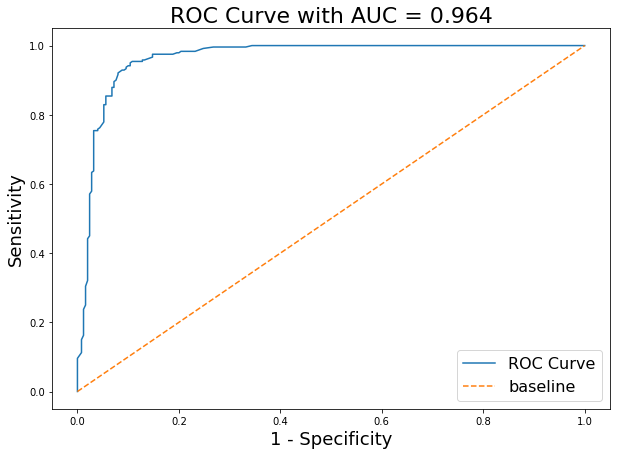

In [20]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

---
## Insights from random forest model

### Words with largest coefficient values 

From the top 500 most significant words (```max_features```), I have plotted a bar graph to show which words affect the prediction of target vector ```is_depression``` the most.

**The top 30 words have the largest feature importances values. These words have the highest weightage in affecting the probability of whether ```is_depression```  = 1 or 0.**
- The top 30 words are: ```abusive, abuse, police, leave, violence, depression, ex, domestic, abuser, life, relationship, order, hit, told, house, got, said, together, feel, physically, call, abused, people, advice, husband, back, phone, home, violent, like```

In [21]:
feature_impt = best_gscv.named_steps['rf'].feature_importances_
features = best_gscv.named_steps['tvec'].get_feature_names()

#creating dataframe of words and feature importance
feat_df = pd.DataFrame({'word':features, 'feature_impt':feature_impt})
feat_df.head()

,word,feature_impt
0,10,0.000684
1,20,0.000400
2,able,0.000647
3,abuse,0.059552
4,abused,0.008003


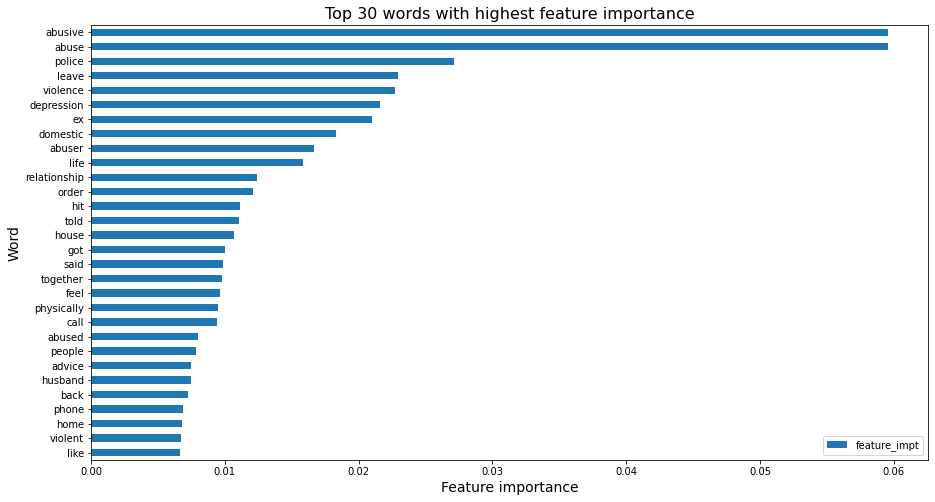

In [22]:
#plot bar chart with 30 words with highest feature importance
top_30 = feat_df.sort_values(by = 'feature_impt', ascending=False)[:30]
top_30[::-1].plot.barh('word', figsize=(15,8))
plt.title ('Top 30 words with highest feature importance', fontsize=16)
plt.xlabel('Feature importance', fontsize = 14)
plt.ylabel('Word', fontsize = 14);

---
## Conclusion 

The best feature for logistic regression model was the ```all_words``` column, vectorized with ```TF-IDFVectorizer```. It gave a train accuracy score of 1 and test accuracy score of 0.92. There is some overfitting in the random forest model given the difference between the train and test scores. The ROC AUC score of 0.96 means that there is little overlap between false positive and false negatives, thereby minimising wrong predictions. 

This model will be taken into consideration for the final production model. 

#### Pros and Cons of random forest model
- Pros
    - Lower variance than decision tree and bagging models 
- Cons
    - Even though it has a lower variance and therefore lower likelihood that the model is overfit compared to other decision tree models, it still has a higher variance between train and test scores than the multinomial NB and logistic regression models.
    - Does not generate coefficients of each feature, unlike other models, more difficult to visualise how each the presence of 1 word increases/decreases probability of ```is_depression``` = 1. 
    
#### The next notebook will determine the final production model based on the performance of the multinomial NB, logistic regression and random forest best models. 